# Modelling the addition of a battery into home solar system:
***
**Battery of interest:**   Enphase Encharge 10  
        *Spec Sheet: https://enphase.com/sites/default/files/downloads/support/Encharge-10-DS-EN-US.pdf*

OUTPUT (AC) @ 240 VAC¹:
>         Rated (continuous) output power² 3.84 kVA  
        Peak output power 5.7 kVA (10 seconds)  
        Nominal voltage / range 240 / 211 — 264 VAC  
        Nominal frequency / range 60 / 57 — 61 Hz
        Rated output current 16 A
        Peak output current 24.6A (10 seconds)
        Power factor (adjustable) 0.85 leading ... 0.85 lagging
        Maximum units per 20 A branch circuit 1 unit (single phase)
        Interconnection Single-phase
        Maximum AC short circuit fault current over 3 cycles 69.6 Arms
        Round trip efficiency² 89%
        
BATTERY:
>         Total capacity 10.5 kWh
        Usable capacity 10.08 kWh
        Round trip efficiency 96%  
        Nominal DC voltage 67.2 V
        Maximum DC voltage 73.5 V
        Ambient operating temperature range -15º C to 55º C (5º F to 131º F) non-condensing
        Optimum operating temperature range 0º C to 30º C (32º F to 86º F)
        Chemistry Lithium iron phosphate (LFP)>
        
Limited Warranty(3):
>        >70% capacity, up to 10 years or 4000 cycles

Foot Notes:
1. Supported in backup/off grid operations
2. AC to Battery to AC at 50% power rating.
3. Whichever occurs first. Restrictions apply

### My assumptions based on these specs:
#### Efficiencies:
- one way efficiency = $\sqrt{\text{Round Trip Efficiency}}$  
- 98.0% DC charging effeciency from solar (assuming it does not have to be inverted and uninverted)
- 94.3% AC charging efficiency from grid  
- 94.3% AC discharge efficiency to home  
- Actual max output power = Apparent max (kWA) * Power Factor 
    - 3.84 (kVA) * 50% = 1.92kW
    - (i got 50% from footnote 2 above)

#### Worst Case Battery Life Span:
- Usable capacity drops by 30% over 10 years or 4k cycles
    - you lose: $\frac{30\text{%}}{4k Cycles}$ $\text{= 0.0075% per 1 cycle}$
- What defines a 'cycle'?
    - From enphase community forum [here](https://community.enphase.com/s/question/0D52G00004NITyPSAX/your-warranty-for-the-storage-system-is-4000-cycles-or-10-years-whichever-comes-first-how-do-you-calculate-each-cycle-if-i-never-fully-discharge-and-i-charge-and-discharge-on-small-phases-how-do-i-keep-track-of-this-in-my-elighthen-app-to-see-expiratio):
> The 4000 cycle is 4000 full cycle, which is equivalent to 2.8MWh AC energy throughput per kWh of rated capacity over the warranty period. This is equal to 9,408 kWh throughput per Encharge 3 base unit and 28,224 kWh throughput per Encharge 10.
>
>You can see the lifetime energy discharged from your system in the Enlighten App, in Energy Page, by selecting the “Life Time” on the top of the page. Compare the life time Discharged energy to the warrantied throughput (9,408 kWh per Encharge 3 base unit kWh).

    - So I interpret this to mean that each cycle is counted when you've used 28.224 MWh of AC energy
        - 28,224 kWh (usable AC) = 2,800 kWh ($\frac{\text{usable AC kWh}}{\text{DC kWh}}$) * 10.080 kWh (DC kWh)
- For the sake of this model this means that for every 28,224 kWh pulled from the battery I need to reduce my usable capacity by 0.0075%
   
   That can't be right...
    - instead:
        - 4k cycles = 28,224 kWh  
        - 1 cycle = 28,224/4000 = 7kWh

### Questions:
* Do i need to add inverter losses? or is this baked into the 'AC Round Trip Efficiency'

- chat w/ Travis
    - Enphase Packs has microinverters packaged inside
    - efficiency assumptions
        - Prod numbers are after being inverted?
        - charging
            - 0.943
        - discharging
            - 0.943
     
### Still To Do:
- Factor in capicity decrease over time into max charge capacity
- Factor in max current output and input for the battery
- Factor in what we don't sell back to the grid - do we need to? 


### Generator Alternatives:

Bermy Quotes:
- https://www.facebook.com/Bermuda-Electric-Generators-103247934411677/photos/a.103251671077970/476672477069219

Generac 10kW:
- https://www.northerntool.com/shop/tools/product_200736934_200736934
- 10,000 Surge Watts, 8000 Rated Watts
- $999.00 in US
- ~2k in Berm

Generac 5802 XG 10000-Running-Watt Gasoline Portable Generator
- https://www.homedepot.com/p/XG-10-000-Watt-Gasoline-Powered-Electric-Start-Portable-Generator-5802/202322589  
- $ 2299.00 in US   

- $ 5,160.00 delivered in BDA

PowerHorse 9kW:  
- https://www.northerntool.com/shop/tools/product_200664810_200664810
- 9000 Surge Watts, 7250 Rated Watts
- $929.99 in US
- ~2k in Berm


In [21]:
import pandas as pd
import numpy as np
from dataclasses import dataclass
import holoviews as hv
import hvplot
import hvplot.pandas
import matplotlib.pyplot as plt
import pytz
from datetime import timedelta

%matplotlib inline
plt.style.use('ggplot')
pd.options.display.max_rows = 10


### Import Historical Data:

In [22]:
pd.set_option('display.max_rows',10)

raw_df = pd.read_csv('./enphase-data-2019-2020.csv')


raw_df.drop(columns='Unnamed: 0',inplace=True)
raw_df.rename(columns={'Date/Time':'time',
                   'Energy Produced (Wh)':'prod',
                   'Energy Consumed (Wh)':'cons',
                   'Exported to Grid (Wh)':'exp',
                   'Imported from Grid (Wh)':'imp'}, inplace=True)

raw_df['time'] = pd.to_datetime(raw_df['time'],utc=True)
raw_df.time = raw_df.time.dt.tz_convert('Atlantic/Bermuda')
raw_df.sort_values(by='time',inplace=True,ignore_index=True)
raw_df.set_index('time',inplace=True)

## Plotting Unconstrained Battery Level
---
To get an initial look at the data and how 'balanced' our house energy system is i'm going to model an unconstrained battery into the system to see if it ultimately ends up being very over-charged or very over-dischared over the various seasons and years.

**What do I mean by how balanced our house energy system is?**   
*how close does our overproduction from solar during the day match what we consume during non-production hours throughout the year.*

**What is an unconstrained battery?**
*an unconstrained battery in this case is a battery with infinitely large capacty and no limitations on how fast you can charge or discharge it. In my case i'm going to start at an initial battery level of 0 and see if it ends up being ultimately more discharged or charged from it's startling level*

In [23]:
raw_df

,prod,cons,exp,imp
time,,,,
2019-01-01 00:00:00-04:00,0,207,0,207
2019-01-01 00:15:00-04:00,0,189,0,189
2019-01-01 00:30:00-04:00,0,174,0,174
2019-01-01 00:45:00-04:00,0,146,0,146
2019-01-01 01:00:00-04:00,0,727,0,727
...,...,...,...,...
2020-12-31 22:45:00-04:00,0,185,0,185
2020-12-31 23:00:00-04:00,0,205,0,205
2020-12-31 23:15:00-04:00,0,201,0,201


In [24]:
df = raw_df.copy()

plot_scale_factor = 5
df['unconst_batt_level'] = (df['prod'].cumsum() - df['cons'].cumsum()) / plot_scale_factor

shift_val = -4 # used to account for the delay on the EWM moving average

line_alpha = 0.5
line_width = 1
line_color = 'black'

text_size = '8pt'
text_alpha = 0.8
text_color = 'gray'

line1 = hv.VLine(pd.to_datetime('3/1/2019'))
line2 = hv.VLine(pd.to_datetime('6/1/2019'))
line3 = hv.VLine(pd.to_datetime('9/1/2019'))
line4 = hv.VLine(pd.to_datetime('12/1/2019'))
line5 = hv.VLine(pd.to_datetime('3/1/2020'))
line6 = hv.VLine(pd.to_datetime('6/1/2020'))
line7 = hv.VLine(pd.to_datetime('9/1/2020'))
line8 = hv.VLine(pd.to_datetime('12/1/2020'))

# Setting option defaults wasn't working.. do it the long way
line1.opts(color=line_color, line_dash='dashed', line_width= line_width, alpha= line_alpha)
line2.opts(color=line_color, line_dash='dashed', line_width= line_width, alpha= line_alpha)
line3.opts(color=line_color, line_dash='dashed', line_width= line_width, alpha= line_alpha)
line4.opts(color=line_color, line_dash='dashed', line_width= line_width, alpha= line_alpha)
line5.opts(color=line_color, line_dash='dashed', line_width= line_width, alpha= line_alpha)
line6.opts(color=line_color, line_dash='dashed', line_width= line_width, alpha= line_alpha)
line7.opts(color=line_color, line_dash='dashed', line_width= line_width, alpha= line_alpha)
line8.opts(color=line_color, line_dash='dashed', line_width= line_width, alpha= line_alpha)

text1 = hv.Text(pd.to_datetime('4/15/2019'),-5e5,'SPRING')
text2 = hv.Text(pd.to_datetime('7/15/2019'),-5e5,'SUMMER')
text3 = hv.Text(pd.to_datetime('10/15/2019'),-5e5,'FALL')
text4 = hv.Text(pd.to_datetime('1/15/2020'),-5e5,'WINTER')
text5 = hv.Text(pd.to_datetime('4/15/2020'),-5e5,'SPRING')
text6 = hv.Text(pd.to_datetime('7/15/2020'),-5e5,'SUMMER')
text7 = hv.Text(pd.to_datetime('10/15/2020'),-5e5,'FALL')


text1.opts(text_color=text_color, text_alpha=text_alpha, text_font_size=text_size)
text2.opts(text_color=text_color, text_alpha=text_alpha, text_font_size=text_size)
text3.opts(text_color=text_color, text_alpha=text_alpha, text_font_size=text_size)
text4.opts(text_color=text_color, text_alpha=text_alpha, text_font_size=text_size)
text5.opts(text_color=text_color, text_alpha=text_alpha, text_font_size=text_size)
text6.opts(text_color=text_color, text_alpha=text_alpha, text_font_size=text_size)
text7.opts(text_color=text_color, text_alpha=text_alpha, text_font_size=text_size)

df.rename(columns={'cons':'Consumption (Wh)','prod':'Production (Wh)'},inplace=True)

plot1 = df.drop(columns=['exp',
                 'imp',
                 'unconst_batt_level']).resample('W').sum().ewm(span=20).mean().shift(shift_val).hvplot.line(
    hover_line_alpha=0.6,
    grid=True,
    width=900,
    height=400)

plot2 = df.drop(columns=['exp','imp','Consumption (Wh)','Production (Wh)']).hvplot.area(alpha=0.2,
                                                         line_color='green',
                                                         color='green',
                                                         label=('Unconstrained Battery Capacity'),
                                                        ylabel='Energy (Wh) (Battery is scaled to fit)',
                                                                title='Unconstrained Battery Level over 2 years')

plots = plot1 * plot2
lines = line1 * line2 * line3 * line4 * line5 * line6 * line7 * line8 
text = text1 * text2 * text3 * text4 * text5 * text6 * text7

plots * lines * text

#hv.help(hv.Text)

:Overlay
   .NdOverlay.I                         :NdOverlay   [Variable]
      :Curve   [time]   (value)
   .Area.Unconstrained_Battery_Capacity :Area   [time]   (unconst_batt_level)
   .VLine.I                             :VLine   [x,y]
   .VLine.II                            :VLine   [x,y]
   .VLine.III                           :VLine   [x,y]
   .VLine.IV                            :VLine   [x,y]
   .VLine.V                             :VLine   [x,y]
   .VLine.VI                            :VLine   [x,y]
   .VLine.VII                           :VLine   [x,y]
   .VLine.VIII                          :VLine   [x,y]
   .Text.I                              :Text   [x,y]
   .Text.II                             :Text   [x,y]
   .Text.III                            :Text   [x,y]
   .Text.IV                             :Text   [x,y]
   .Text.V                              :Text   [x,y]
   .Text.VI                             :Text   [x,y]
   .Text.VII                            :Text   [x,y]

In [25]:

from bokeh.plotting import figure, output_file, show
from bokeh.resources import CDN
from bokeh.embed import file_html
from bokeh.io import output_notebook

output_notebook()
plot = figure()
plot.circle([1,2], [3,4])
show(plot)
#html = file_html(plot, CDN, "my plot")

Loading BokehJS ...

RuntimeError: Models must be owned by only a single document, BoxAnnotation(id='2659', ...) is already in a doc

<AxesSubplot:xlabel='time'>

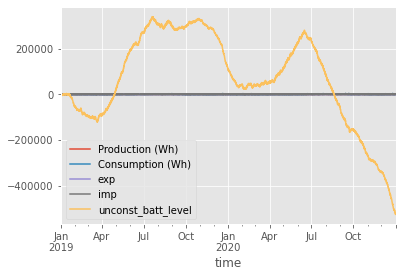

In [5]:
df.plot()

# TESTING... TESTING

### Takeaways:
- You can clearly see the seasonal cycles in the production
- Consumption was was relatively flat until Summer 2020 when it jumped significantly
    - best guess for this jump is that it's a result of more occupants in the house (COVID-19..) using more AC in the summer and more hot water in the winter
- Unconstrained Battery
    - the battery was trending to be net over-charged before the jump in consumption in Summer 2020
    - after the jump the battery capacity was steadily discharging

## Now to constrain the battery:
---

Here I am going to create a battery class to store battery specs as well as the functions that will control how the battery behaves with the system.

Battery behaviour psuedo-code: 
 - if (production > consumption)
     - if (battery_level > min_level) & (battery_level < max_level)
         - charge
     - else 
         - export to grid
 - else if (production < consumption)
     - if (battery_level > min_level) & (battery_level < max_level)
         - discharge
     - else 
         - import from grid